In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import numpy as np


In [18]:
df = pd.read_csv('tows.csv')

In [20]:
df.columns

Index(['Tow Date', 'Vehicle Year', 'Vehicle Make', 'Vehicle Model', 'Notes',
       'Location', 'City', 'lon', 'lat', 'geoid', 'Reason for tow',
       'Trade Name', 'TractFIPS', 'cei', 'cat_cei', 'transit_freq',
       'resident_density', 'pop_density', 'employ_density', 'act_density',
       'median_household_income', 'foreign_born_population',
       'speak_only_english', 'total_population',
       'means_of_transportation_to_work_car_truck_or_van'],
      dtype='object')

C:\Users\Home\AppData\Local\Temp\ipykernel_5044\2156227325.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['foreign_born_proportion'] = df_cleaned['foreign_born_population'] / df_cleaned['total_population']
C:\Users\Home\AppData\Local\Temp\ipykernel_5044\2156227325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['speak_only_english_proportion'] = df_cleaned['speak_only_english'] / df_cleaned['total_population']
C:\Users\Home\AppData\Local\Temp\ipykernel_5044\2156227325.py:8: Se

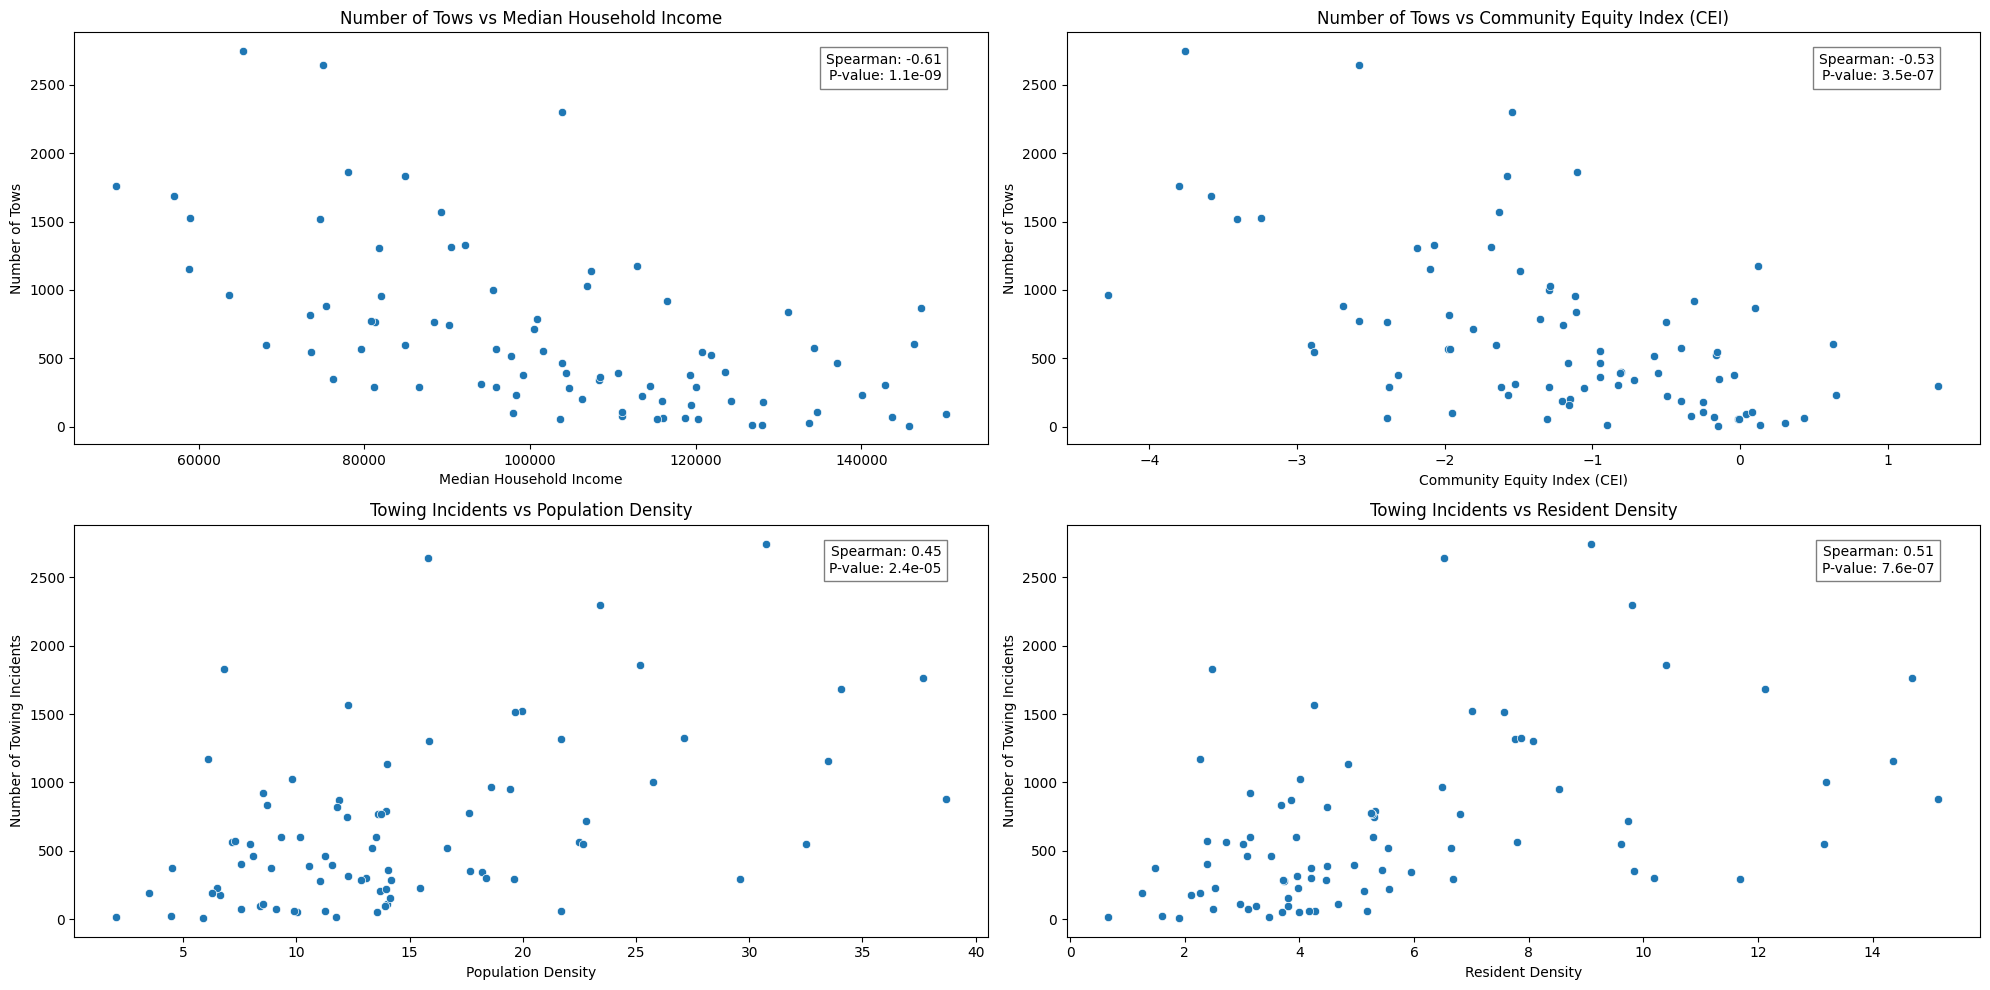

In [26]:


# Clean the data: Remove rows with missing values for key metrics
df_cleaned = df.dropna(subset=['pop_density', 'resident_density', 'median_household_income', 'cei', 'employ_density',
                               'foreign_born_population', 'act_density', 'total_population', 'speak_only_english', 
                               'means_of_transportation_to_work_car_truck_or_van'])

df_cleaned['foreign_born_proportion'] = df_cleaned['foreign_born_population'] / df_cleaned['total_population']
df_cleaned['speak_only_english_proportion'] = df_cleaned['speak_only_english'] / df_cleaned['total_population']
df_cleaned['means_of_transportation_proportion'] = df_cleaned['means_of_transportation_to_work_car_truck_or_van'] / df_cleaned['total_population']

# Remove outliers using the Interquartile Range (IQR) method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]

# Remove outliers from key columns
df_cleaned = remove_outliers(df_cleaned, 'median_household_income')
df_cleaned = remove_outliers(df_cleaned, 'cei')
df_cleaned = remove_outliers(df_cleaned, 'pop_density')
df_cleaned = remove_outliers(df_cleaned, 'resident_density')
df_cleaned = remove_outliers(df_cleaned, 'employ_density')
df_cleaned = remove_outliers(df_cleaned, 'act_density')
df_cleaned = remove_outliers(df_cleaned, 'foreign_born_proportion')
df_cleaned = remove_outliers(df_cleaned, 'speak_only_english_proportion')
df_cleaned = remove_outliers(df_cleaned, 'means_of_transportation_proportion')

# Group the data by 'TractFIPS' to aggregate the number of tows per tract
grouped_data = df_cleaned.groupby('TractFIPS').agg({
    'median_household_income': 'mean',   # Mean income for each tract
    'cei': 'mean',                       # Mean CEI for each tract
    'pop_density': 'mean',               # Mean population density for each tract
    'resident_density': 'mean',          # Mean resident density for each tract
    'employ_density': 'mean',
    'act_density': 'mean',
    'foreign_born_proportion': 'mean',
    'speak_only_english_proportion': 'mean',
    'means_of_transportation_proportion': 'mean',
    'geoid': 'count'                 # Number of tows in each tract, assuming 'Unnamed: 0' is a unique identifier
}).reset_index()

# Rename columns for better understanding
grouped_data.rename(columns={'geoid': 'number_of_tows'}, inplace=True)

# Drop rows with missing values in median_household_income or cei for correlation analysis
grouped_data_cleaned = grouped_data.dropna(subset=['median_household_income', 'cei'])

# Statistical Testing for Significance
# Spearman correlation for Median Household Income and Number of Tows
spearman_income_tows, p_value_income_tows = stats.spearmanr(grouped_data_cleaned['median_household_income'], grouped_data_cleaned['number_of_tows'])

# Spearman correlation for CEI and Number of Tows
spearman_cei_tows, p_value_cei_tows = stats.spearmanr(grouped_data_cleaned['cei'], grouped_data_cleaned['number_of_tows'])

# Spearman correlation for Population Density and Number of Tows
spearman_pop_density_tows, p_value_pop_density_tows = stats.spearmanr(grouped_data_cleaned['pop_density'], grouped_data_cleaned['number_of_tows'])

# Spearman correlation for Resident Density and Number of Tows
spearman_res_density_tows, p_value_res_density_tows = stats.spearmanr(grouped_data_cleaned['resident_density'], grouped_data_cleaned['number_of_tows'])

# Visualization: Scatter Plots to Show Correlations
plt.figure(figsize=(20, 10))

# Scatter plot for Median Household Income vs Number of Tows
plt.subplot(2, 2, 1)
sns.scatterplot(x='median_household_income', y='number_of_tows', data=grouped_data_cleaned)
plt.title('Number of Tows vs Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Number of Tows')
plt.text(0.95, 0.95, f"Spearman: {spearman_income_tows:.2f}\nP-value: {p_value_income_tows:.2g}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

# Scatter plot for CEI vs Number of Tows
plt.subplot(2, 2, 2)
sns.scatterplot(x='cei', y='number_of_tows', data=grouped_data_cleaned)
plt.title('Number of Tows vs Community Equity Index (CEI)')
plt.xlabel('Community Equity Index (CEI)')
plt.ylabel('Number of Tows')
plt.text(0.95, 0.95, f"Spearman: {spearman_cei_tows:.2f}\nP-value: {p_value_cei_tows:.2g}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

# Scatter plot for Population Density vs Number of Tows
plt.subplot(2, 2, 3)
sns.scatterplot(x='pop_density', y='number_of_tows', data=grouped_data_cleaned)
plt.title('Towing Incidents vs Population Density')
plt.xlabel('Population Density')
plt.ylabel('Number of Towing Incidents')
plt.text(0.95, 0.95, f"Spearman: {spearman_pop_density_tows:.2f}\nP-value: {p_value_pop_density_tows:.2g}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

# Scatter plot for Resident Density vs Number of Tows
plt.subplot(2, 2, 4)
sns.scatterplot(x='resident_density', y='number_of_tows', data=grouped_data_cleaned)
plt.title('Towing Incidents vs Resident Density')
plt.xlabel('Resident Density')
plt.ylabel('Number of Towing Incidents')
plt.text(0.95, 0.95, f"Spearman: {spearman_res_density_tows:.2f}\nP-value: {p_value_res_density_tows:.2g}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


In [35]:
# Calculate Spearman correlations
correlations = {}
for column in grouped_data.columns:
    if column != 'number_of_tows':
        correlation = grouped_data['number_of_tows'].corr(grouped_data[column], method='spearman')
        correlations[column] = correlation

# Convert to DataFrame and sort by absolute correlation value
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
corr_df = corr_df.sort_values('correlation', key=abs, ascending=False)

# Display results
print("Spearman Correlations with number_of_tows:")
print(corr_df)

# Print statistical significance
from scipy import stats
print("\nStatistical Significance:")
for column in grouped_data.columns:
    if column != 'number_of_tows':
        correlation, p_value = stats.spearmanr(grouped_data['number_of_tows'], grouped_data[column])
        print(f"{column}: correlation = {correlation:.4f}, p-value = {p_value:.3e}")

Spearman Correlations with number_of_tows:
                                    correlation
median_household_income               -0.607985
act_density                            0.558007
cei                                   -0.525094
resident_density                       0.511723
pop_density                            0.445813
employ_density                         0.388646
foreign_born_proportion                0.291430
TractFIPS                             -0.270324
speak_only_english_proportion         -0.231345
means_of_transportation_proportion    -0.032483

Statistical Significance:
TractFIPS: correlation = -0.2703, p-value = 1.345e-02
median_household_income: correlation = -0.6080, p-value = 1.089e-09
cei: correlation = -0.5251, p-value = 3.463e-07
pop_density: correlation = 0.4458, p-value = 2.403e-05
resident_density: correlation = 0.5117, p-value = 7.643e-07
employ_density: correlation = 0.3886, p-value = 2.825e-04
act_density: correlation = 0.5580, p-value = 4.238e-08
fore

Empty DataFrame
Columns: []
Index: []

| Variable                         | Spearman Correlation Coefficient | P-value       | Interpretation                                     |
|----------------------------------|----------------------------------|--------------|----------------------------------------------------|
| Median Household Income          | -0.521                           | 4.41e-09     | Negative correlation suggests lower income areas are associated with more towing incidents. |
| Community Equity Index (CEI)     | -0.513                           | 8.66e-09     | Negative correlation suggests lower equity areas are associated with more towing incidents. |
| Population Density               | 0.401                            | 1.26e-05     | Weak positive correlation suggests towing may increase with population density.   |
| Resident Density                 | 0.417                            | 5.15e-06     | Significant relationship with residential density.          

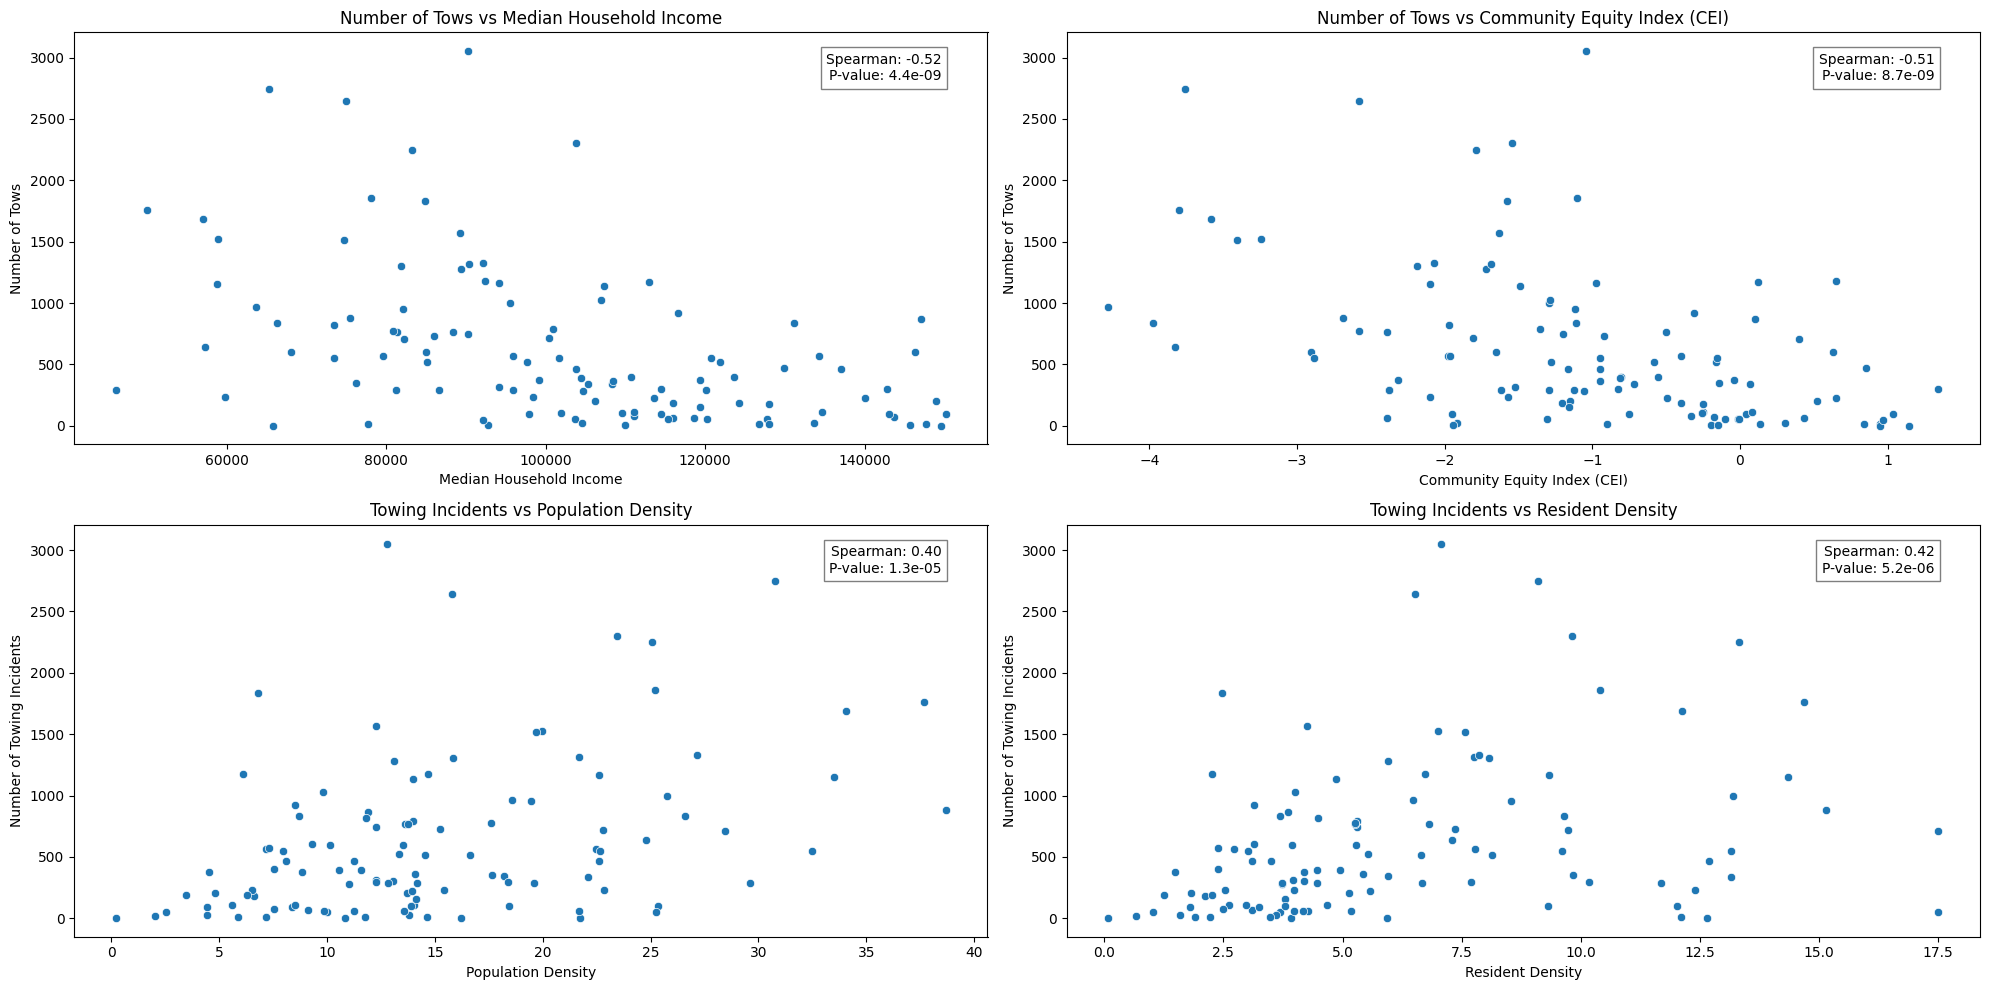

In [7]:
# Statistical Testing for Significance
# Spearman correlation for Median Household Income and Number of Tows
spearman_income_tows, p_value_income_tows = stats.spearmanr(grouped_data_cleaned['median_household_income'], grouped_data_cleaned['number_of_tows'])

# Spearman correlation for CEI and Number of Tows
spearman_cei_tows, p_value_cei_tows = stats.spearmanr(grouped_data_cleaned['cei'], grouped_data_cleaned['number_of_tows'])

# Spearman correlation for Population Density and Number of Tows
spearman_pop_density_tows, p_value_pop_density_tows = stats.spearmanr(grouped_data_cleaned['pop_density'], grouped_data_cleaned['number_of_tows'])

# Spearman correlation for Resident Density and Number of Tows
spearman_res_density_tows, p_value_res_density_tows = stats.spearmanr(grouped_data_cleaned['resident_density'], grouped_data_cleaned['number_of_tows'])

summary_table = pd.DataFrame()
print(summary_table)

# Display summary table in Markdown format
markdown_table = f"""
| Variable                         | Spearman Correlation Coefficient | P-value       | Interpretation                                     |
|----------------------------------|----------------------------------|--------------|----------------------------------------------------|
| Median Household Income          | {spearman_income_tows:.3f}                           | {p_value_income_tows:.2e}     | {'Negative correlation suggests lower income areas are associated with more towing incidents.' if spearman_income_tows < 0 else 'Positive correlation suggests higher income areas are associated with more towing incidents.'} |
| Community Equity Index (CEI)     | {spearman_cei_tows:.3f}                           | {p_value_cei_tows:.2e}     | {'Negative correlation suggests lower equity areas are associated with more towing incidents.' if spearman_cei_tows < 0 else 'Positive correlation suggests higher equity areas are associated with more towing incidents.'} |
| Population Density               | {spearman_pop_density_tows:.3f}                            | {p_value_pop_density_tows:.2e}     | {'Weak positive correlation suggests towing may increase with population density.' if spearman_pop_density_tows > 0 else 'Weak negative correlation suggests towing may decrease with population density.'}   |
| Resident Density                 | {spearman_res_density_tows:.3f}                            | {p_value_res_density_tows:.2e}     | {'Significant relationship with residential density.' if abs(spearman_res_density_tows) > 0.2 else 'Weak correlation suggests residential density has little effect on towing incidents.'}                              |
"""
print(markdown_table)

# Visualization: Scatter Plots to Show Correlations
plt.figure(figsize=(20, 10))

# Scatter plot for Median Household Income vs Number of Tows
plt.subplot(2, 2, 1)
sns.scatterplot(x='median_household_income', y='number_of_tows', data=grouped_data_cleaned)
plt.title('Number of Tows vs Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Number of Tows')
plt.text(0.95, 0.95, f"Spearman: {spearman_income_tows:.2f}\nP-value: {p_value_income_tows:.2g}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

# Scatter plot for CEI vs Number of Tows
plt.subplot(2, 2, 2)
sns.scatterplot(x='cei', y='number_of_tows', data=grouped_data_cleaned)
plt.title('Number of Tows vs Community Equity Index (CEI)')
plt.xlabel('Community Equity Index (CEI)')
plt.ylabel('Number of Tows')
plt.text(0.95, 0.95, f"Spearman: {spearman_cei_tows:.2f}\nP-value: {p_value_cei_tows:.2g}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

# Scatter plot for Population Density vs Number of Tows
plt.subplot(2, 2, 3)
sns.scatterplot(x='pop_density', y='number_of_tows', data=grouped_data_cleaned)
plt.title('Towing Incidents vs Population Density')
plt.xlabel('Population Density')
plt.ylabel('Number of Towing Incidents')
plt.text(0.95, 0.95, f"Spearman: {spearman_pop_density_tows:.2f}\nP-value: {p_value_pop_density_tows:.2g}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

# Scatter plot for Resident Density vs Number of Tows
plt.subplot(2, 2, 4)
sns.scatterplot(x='resident_density', y='number_of_tows', data=grouped_data_cleaned)
plt.title('Towing Incidents vs Resident Density')
plt.xlabel('Resident Density')
plt.ylabel('Number of Towing Incidents')
plt.text(0.95, 0.95, f"Spearman: {spearman_res_density_tows:.2f}\nP-value: {p_value_res_density_tows:.2g}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.savefig('correlation.png', format='png')

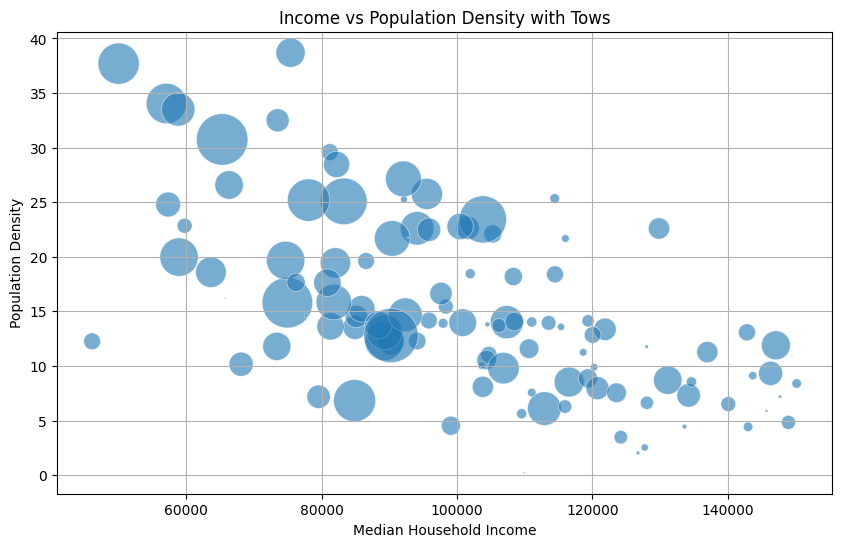

In [8]:

# Rename columns for better understanding
grouped_data.rename(columns={'Unnamed: 0': 'number_of_tows'}, inplace=True)

# Bubble Plot: Bubble size proportional to Number of Tows
plt.figure(figsize=(10, 6))
plt.scatter(
    grouped_data['median_household_income'],
    grouped_data['pop_density'],
    s=grouped_data['number_of_tows'] * 0.5,  # Bubble size proportional to number of tows
    alpha=0.6, edgecolors='w', linewidth=0.5
)
plt.title('Income vs Population Density with Tows')
plt.xlabel('Median Household Income')
plt.ylabel('Population Density')
plt.grid(True)
plt.savefig('income_vs_population_density_with_tows.png', format='png')
plt.show()

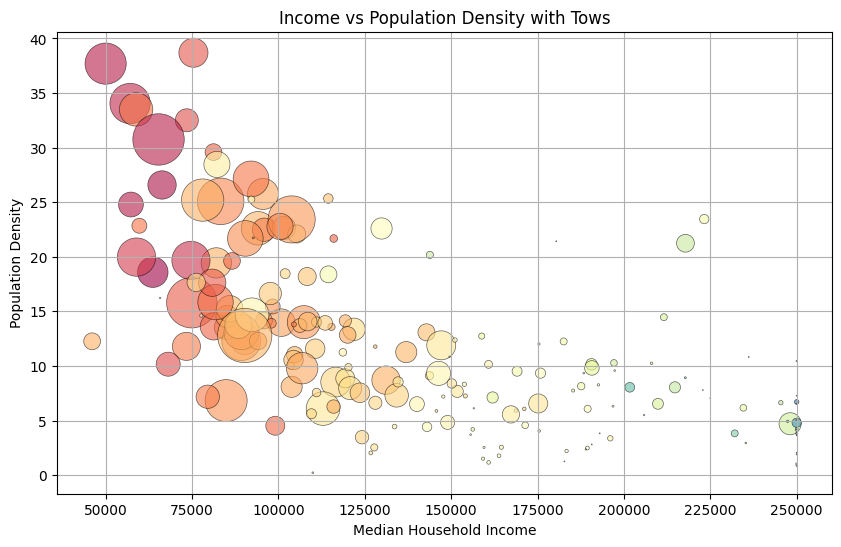

In [9]:
# Clean the data: Remove rows with missing values for key metrics
df_cleaned = df.dropna(subset=['pop_density', 'resident_density', 'median_household_income', 'cei'])

# Remove outliers using the Interquartile Range (IQR) method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]

# Remove outliers from Population Density and Resident Density only
df_cleaned = remove_outliers(df_cleaned, 'pop_density')
df_cleaned = remove_outliers(df_cleaned, 'resident_density')

# Group the data by 'TractFIPS' to aggregate the number of tows per tract
grouped_data = df_cleaned.groupby('TractFIPS').agg({
    'median_household_income': 'mean',   # Mean income for each tract
    'pop_density': 'mean',               # Mean population density for each tract
    'cei':'mean',
    'geoid': 'count'                # Number of tows in each tract, assuming 'Unnamed: 0' is a unique identifier
}).reset_index()

# Rename columns for better understanding
grouped_data.rename(columns={'geoid': 'number_of_tows'}, inplace=True)

# Bubble Plot: Bubble size proportional to Number of Tows
plt.figure(figsize=(10, 6))
plt.scatter(
    grouped_data['median_household_income'],
    grouped_data['pop_density'],
    s=grouped_data['number_of_tows'] * 0.5,  # Bubble size proportional to number of tows
    alpha=0.6, edgecolors='k', linewidth=0.5, c= grouped_data['cei'], cmap='Spectral'
)
plt.title('Income vs Population Density with Tows')
plt.xlabel('Median Household Income')
plt.ylabel('Population Density')
plt.grid(True)
plt.savefig('income_vs_population_density_with_tows.png', format='png')
plt.show()


In [8]:
df.columns

Index(['Tow Date', 'Vehicle Year', 'Vehicle Make', 'Vehicle Model', 'Notes',
       'Location', 'City', 'lon', 'lat', 'geoid', 'Reason for tow',
       'Trade Name', 'TractFIPS', 'cei', 'cat_cei', 'transit_freq',
       'resident_density', 'pop_density', 'employ_density', 'act_density',
       'median_household_income', 'foreign_born_population',
       'speak_only_english', 'total_population',
       'means_of_transportation_to_work_car_truck_or_van'],
      dtype='object')

In [38]:
import plotly.express as px
import plotly.graph_objects as go

# Create the bubble plot using Plotly Express
fig = px.scatter(grouped_data, 
    x='median_household_income',
    y='pop_density',
    size='number_of_tows',
    color='cei',
    color_continuous_scale='RdYlBu',
    size_max=50,  # Maximum bubble size
    hover_data={
        'median_household_income': ':,.0f',
        'pop_density': ':,.0f',
        'number_of_tows': True,
        'cei': ':.2f'
    },
    template='simple_white',
    title='Income vs Population Density with Number of Towing Incidents',
    labels={
        'median_household_income': 'Median Household Income',
        'pop_density': 'Population Density',
        'number_of_tows': 'Number of Tows',
        'cei': 'Community Equity Index'
    }
)

# Update layout for better visualization
fig.update_layout(
    plot_bgcolor='white',
    width=850,
    height=550,
    coloraxis_colorbar_title='CEI',
    title_font_size=18
)

fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Show the plot
fig.show()

# Save as HTML file for interactive viewing
fig.write_html("towing_bubble_plot.html")

In [10]:


# Group the data by TractFIPS to aggregate the number of tows per tract
grouped_data = df.dropna().groupby('TractFIPS').agg({
    'median_household_income': 'mean',   # Mean income for each tract
    'cei': 'mean',                       # Mean CEI for each tract
    'pop_density': 'mean',               # Mean population density for each tract
    'resident_density': 'mean',          # Mean resident density for each tract
    'speak_only_english': 'mean',
    'total_population': 'mean',
    'means_of_transportation_to_work_car_truck_or_van': 'mean',
    'geoid': 'count'                     # Number of tows in each tract
}).reset_index()

# Rename columns for better understanding
grouped_data.rename(columns={'geoid': 'number_of_tows'}, inplace=True)

# Proportions
grouped_data['speak_only_english_proportion'] = grouped_data['speak_only_english'] / grouped_data['total_population']

# Display first few rows to verify the grouping
print(grouped_data.head())

   TractFIPS  median_household_income       cei  pop_density  \
0   700101.0                 180417.0  1.391523    21.419390   
1   700103.0                 168717.0  1.319964     5.911399   
2   700104.0                 116576.0 -0.309714     8.522206   
3   700105.0                 128063.0 -0.249688     6.625559   
4   700204.0                 109952.0 -0.192755     0.219294   

   resident_density  speak_only_english  total_population  \
0         15.322794              3729.0            4810.0   
1          2.996160              3885.0            5318.0   
2          3.137257              2353.0            5017.0   
3          2.117300              4017.0            6969.0   
4          0.087212              1901.0            2267.0   

   means_of_transportation_to_work_car_truck_or_van  number_of_tows  \
0                                            1625.0               1   
1                                            2261.0              12   
2                                  

In [25]:
import plotly.express as px

# Create the scatter plot
fig = px.scatter(grouped_data, 
    x='speak_only_english_proportion',
    y='number_of_tows',
    color='cei',
    color_continuous_scale='RdYlBu',
    hover_data={
        'speak_only_english': ':,.0f',
        'number_of_tows': True,
        'cei': ':.2f'
    },
    title='Number of Tows vs English-Only Speaking Households',
    labels={
        'speak_only_english': 'Number of English-Only Speaking Households',
        'number_of_tows': 'Number of Tows',
        'cei': 'Community Equity Index'
    }
)

# Update layout
fig.update_layout(
    plot_bgcolor='white',
    width=850,
    height=550,
    coloraxis_colorbar_title='CEI',
    title_font_size=18
)

# Add gridlines and axes
fig.update_xaxes(
    showgrid=True, 
    gridwidth=1, 
    gridcolor='LightGray',
    showline=True,
    linewidth=2,
    linecolor='black',
    mirror=True
)
fig.update_yaxes(
    showgrid=True, 
    gridwidth=1, 
    gridcolor='LightGray',
    showline=True,
    linewidth=2,
    linecolor='black',
    mirror=True
)

# Add black outlines to markers
fig.update_traces(marker=dict(line=dict(color='black', width=1), opacity=0.7))

# Show the plot
fig.show()

# Save as HTML file for interactive viewing
#fig.write_html("towing_english_speaking.html")

In [18]:
grouped_data['speak_only_english_proportion'].describe()



count    190.000000
mean       0.563448
std        0.162284
min        0.158584
25%        0.451553
50%        0.579819
75%        0.689115
max        0.862069
Name: speak_only_english_proportion, dtype: float64

In [19]:
# Spearman correlation for Speak Only English Proportion and Number of Tows
spearman_english_tows, p_value_english_tows = stats.spearmanr(grouped_data['speak_only_english_proportion'], grouped_data['number_of_tows'])
print(f"Spearman correlation: {spearman_english_tows:.2f}, P-value: {p_value_english_tows:.2g}")


Spearman correlation: -0.53, P-value: 3.4e-15


In [5]:
import statsmodels.api as sm 
from statsmodels.formula.api import glm

model_glm = glm(formula = 'number_of_tows ~ speak_only_english_proportion',
                data = grouped_data,
                family = sm.families.Gaussian()).fit()

print(model_glm.params)


Intercept                        1137.869776
speak_only_english_proportion   -1373.117750
dtype: float64


In [6]:
# Fit a poisson regression model
model_poisson = glm(formula = 'number_of_tows ~ speak_only_english_proportion',
                data = grouped_data,
                family = sm.families.Poisson()).fit()
print(model_poisson.params)


Intercept                        7.718309
speak_only_english_proportion   -3.536626
dtype: float64


In [10]:
# Compute average proportion of speak only english
mean_speak_only_english = np.mean(grouped_data['speak_only_english_proportion'])
print(f"Average proportion of speak only english: {mean_speak_only_english:.2f}")

# Extract coefficients from the poisson model
intercept, slope = model_poisson.params

# Compute the estimated mean of y (lambda) at the average speak only english proportion
est_lambda = np.exp(intercept) * np.exp(slope * mean_speak_only_english)
print(f"Estimated mean of y (lambda) at average speak only english proportion: {est_lambda:.2f}")

# Compute confidence intervals for the coefficients
model_poisson_ci = model_poisson.conf_int()
print(f"Confidence intervals for the coefficients: {model_poisson_ci}")


Average proportion of speak only english: 0.56
Estimated mean of y (lambda) at average speak only english proportion: 306.62
Confidence intervals for the coefficients:                                       0         1
Intercept                      7.696530  7.740089
speak_only_english_proportion -3.580669 -3.492583


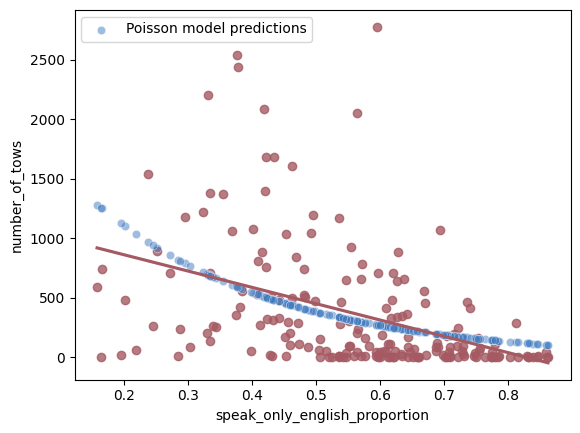

In [16]:
grouped_data['fit_values'] = model_poisson.predict()

sns.regplot(x='speak_only_english_proportion', y='number_of_tows', 
            data=grouped_data, ci=None, color='#a55a63')
sns.scatterplot(x='speak_only_english_proportion', y='fit_values', 
                data=grouped_data, color='#3f7ac0', alpha=0.5, 
                label='Poisson model')
plt.show()


In [18]:
grouped_data.columns

Index(['TractFIPS', 'median_household_income', 'cei', 'pop_density',
       'resident_density', 'speak_only_english', 'total_population',
       'means_of_transportation_to_work_car_truck_or_van', 'number_of_tows',
       'speak_only_english_proportion', 'fit_values'],
      dtype='object')

In [20]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare the data
X = grouped_data[['median_household_income', 'pop_density', 'cei', 'resident_density', 'total_population', 'speak_only_english_proportion']]
y = grouped_data['number_of_tows']

# Standardize the features (important because they're on different scales)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add constant for intercept
X_scaled = sm.add_constant(X_scaled)

# Create and fit the model
model = sm.OLS(y, X_scaled).fit()

# Print summary
print(model.summary())

# Calculate R-squared
r_squared = model.rsquared
adj_r_squared = model.rsquared_adj

print("\nKey Metrics:")
print(f"R-squared: {r_squared:.3f}")
print(f"Adjusted R-squared: {adj_r_squared:.3f}")

# Print coefficients in a more readable format
print("\nStandardized Coefficients:")
for idx, var in enumerate(['Intercept', 'Median Income', 'Population Density', 'CEI', 'Resident Density', 'Total Population', 'Proportion who Speak Only English at Home']):
    coef = model.params[idx]
    p_val = model.pvalues[idx]
    print(f"{var}: {coef:.3f} (p={p_val:.3f})")

                            OLS Regression Results                            
Dep. Variable:         number_of_tows   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     19.90
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           7.68e-18
Time:                        23:21:52   Log-Likelihood:                -1414.1
No. Observations:                 190   AIC:                             2842.
Df Residuals:                     183   BIC:                             2865.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        364.1895     30.543     11.924      0.0

C:\Users\Home\AppData\Local\Temp\ipykernel_18904\1543931074.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.params[idx]
C:\Users\Home\AppData\Local\Temp\ipykernel_18904\1543931074.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val = model.pvalues[idx]


In [25]:
multiple_poisson_model = glm(formula = 'number_of_tows ~ median_household_income + cei + resident_density + speak_only_english_proportion',
                data = grouped_data,
                family = sm.families.Poisson()).fit()
print(multiple_poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         number_of_tows   No. Observations:                  190
Model:                            GLM   Df Residuals:                      185
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26622.
Date:                Sun, 08 Dec 2024   Deviance:                       52065.
Time:                        23:29:16   Pearson chi2:                 6.43e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

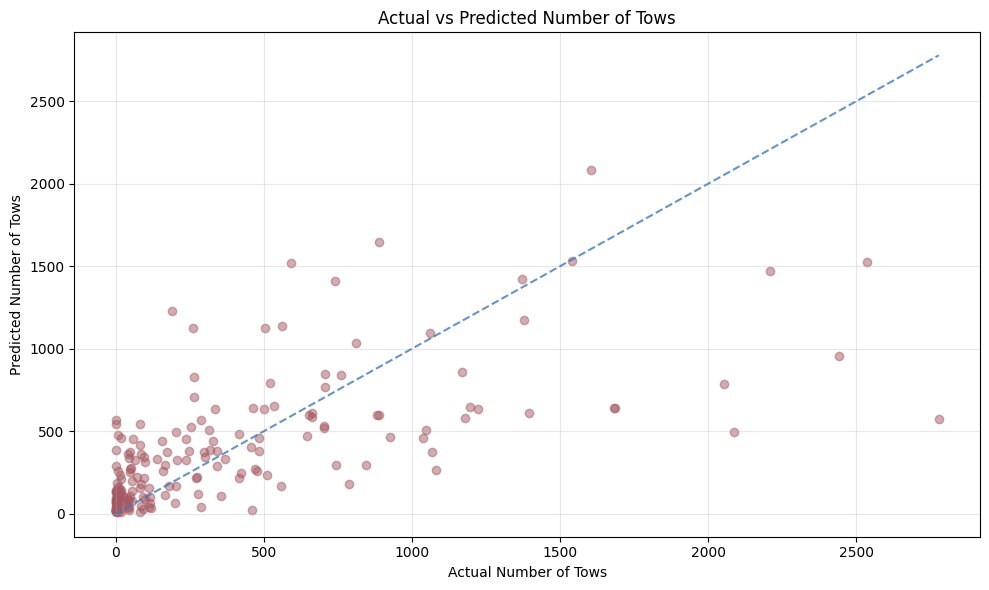


Model Performance Metrics:
AIC: 53253.8
BIC: 51094.0


C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Get coefficients and their confidence intervals
coef = multiple_poisson_model.params
conf_int = multiple_poisson_model.conf_int()

# Create predicted vs actual plot
plt.figure(figsize=(10, 6))

# Get predicted values
predicted = multiple_poisson_model.predict()
actual = grouped_data['number_of_tows']

# Create scatter plot
plt.scatter(actual, predicted, alpha=0.5, color='#a55a63')
plt.plot([0, max(actual)], [0, max(actual)], '--', color='#3f7ac0', alpha=0.8)

# Customize plot
plt.xlabel('Actual Number of Tows')
plt.ylabel('Predicted Number of Tows')
plt.title('Actual vs Predicted Number of Tows')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print model performance metrics
print("\nModel Performance Metrics:")
print(f"AIC: {multiple_poisson_model.aic:.1f}")
print(f"BIC: {multiple_poisson_model.bic:.1f}")

In [11]:
grouped_data.describe()

,TractFIPS,median_household_income,cei,pop_density,resident_density,speak_only_english,total_population,means_of_transportation_to_work_car_truck_or_van,number_of_tows,speak_only_english_proportion
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,702240.794737,139573.663158,0.123350,13.278147,5.717687,2596.700000,4696.568421,1574.294737,364.189474,0.563448
std,1694.012392,55056.023001,1.944070,12.188951,6.580317,1066.114038,1569.053411,684.223692,532.520080,0.162284
min,700101.000000,46087.000000,-4.278186,0.219294,0.087212,604.000000,1434.000000,82.000000,1.000000,0.158584
25%,700832.250000,95850.000000,-1.201113,6.359160,2.233660,1752.250000,3566.250000,1080.000000,12.250000,0.451553
50%,701463.000000,127893.000000,0.054882,10.359989,3.818329,2561.500000,4618.000000,1473.500000,115.000000,0.579819
75%,703301.750000,179277.000000,1.335437,16.531029,6.957085,3285.500000,5713.500000,2005.000000,497.750000,0.689115
max,706012.000000,250001.000000,6.172477,125.984040,67.463486,5530.000000,8602.000000,3359.000000,2779.000000,0.862069


In [16]:
# Group by Trade Name and count tows
top_companies = df.groupby('Trade Name').size().sort_values(ascending=False).head(10)

print("Number of tows by top 5 companies:")
for company, count in top_companies.items():
    print(f"{company}: {count:,} tows")

# Calculate percentage of total tows
total_tows = len(df)
top_5_total = top_companies.sum()
percentage = (top_5_total / total_tows) * 100

print(f"\nTotal tows by top 5 companies: {top_5_total:,}")
print(f"Percentage of all tows: {percentage:.1f}%")

Number of tows by top 5 companies:
Henry's Wrecker Service: 36,573 tows
Authorized Towing: 16,478 tows
Prestige: 9,994 tows
Speedy Towing: 7,248 tows
Big Tow: 3,580 tows
Drive Towing: 3,305 tows
Auburn Towing, Inc.: 3,154 tows
Millers's Towing & Recovery, LLC: 2,387 tows
Ricky's Towing & Recovery, LLC: 2,022 tows
EC Towing Inc.: 1,134 tows

Total tows by top 5 companies: 85,875
Percentage of all tows: 92.3%
